In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

import math
from pathlib import Path
import os
import tempfile
import shutil
from collections import defaultdict

import cv2
from matplotlib import pyplot as plt
import numpy as np


import config
from models import note_classifier, note_detector
from pecha import PechaService

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"

## Find Pedurma Note Marker

In [82]:
def sort_matches(boxes):
    """
    Group bounding boxes into lines and then sort each line from left to right.

    Parameters:
    - boxes: List of tuples, where each tuple represents (x, y, w, h) of a bounding box

    Returns:
    - List of lists, where each sublist contains tuples sorted by x and grouped by line
    """
    # Sort boxes primarily by 'y' to align them into lines
    boxes.sort(key=lambda box: box[1])

    # Group boxes by lines using a vertical threshold
    lines = []
    current_line = []
    current_y = boxes[0][1]

    for box in boxes:
        # If a box's top is within the line vertical range, add it to the current line
        if abs(box[1] - current_y) < 20:  # threshold can be adjusted
            current_line.append(box)
        else:
            # Sort the current line by 'x' before adding to lines
            current_line.sort(key=lambda box: box[0])
            lines.append(current_line)
            current_line = [box]
            current_y = box[1]

    # Don't forget to add the last line
    current_line.sort(key=lambda box: box[0])
    lines.append(current_line)

    # Flatten the list of lists
    flattened_list = [box for line in lines for box in line]
    return flattened_list

def is_note_maker(img, match):
    x, y, w, h = match
    match_img = img[y:y+h, x:x+w]
    # plt.imshow(match_img)
    # plt.show()
    with tempfile.TemporaryDirectory() as tmpdir:
        match_img_fn = Path(tmpdir) / "match.jpg"
        cv2.imwrite(str(match_img_fn), match_img)
        score = note_classifier.predict(match_img_fn)
        return True if score > 0.89 else False
        

def find_pedurma_note_number(image, edged=True, imshow=False, check=True, model=True) -> list[tuple[int, int, int, int]]:
    """Find pedurma note number position in the give image.

    Returns:
        - unique_matches: list of unique matches, i.e., [(x, y, w, h), ...]
    """

    def find_unique_matches(matches):
        def are_points_close(point1, point2, tolerance):
            return math.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2) <= tolerance
        
        unique_matches = []
        tolerance = 10
        
        for current_point in matches:
            if not any(are_points_close(current_point, unique_point, tolerance) for unique_point in unique_matches):
                unique_matches.append(current_point)

        return unique_matches

    if isinstance(image, (Path, str)):            
        img = cv2.imread(str(image_fn))
    else:
        img = image.copy()

    if model:
        matches = note_detector.predict(image)
    else:
        matches = []
        for template_fn in sorted(config.NOTE_MAKER_TEMPLATES_PATH.iterdir()):
            if not template_fn.name.endswith(".png"): continue
            template = cv2.imread(str(template_fn))
            single_matches = match_template(img, template, edged=edged)
            matches.extend(single_matches)

    
    
    if not matches:
        return None

    unique_matches = find_unique_matches(matches)
    if check:
        final_matches = [match for match in unique_matches if is_note_maker(img, match)]
    else:
        final_matches = unique_matches

    if final_matches:
        sorted_matches = sort_matches(final_matches)
    else:
        sorted_matches = []
    

    if imshow:
        for x, y, w, h in sorted_matches:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 1)
        plt.figure(figsize=(20, 15), dpi=100)
        plt.imshow(img)
        plt.show()
    
        
    return sorted_matches


image 1/1 /Users/10zinten/Developer/OpenPecha/Pedurma/images/W1PD95844/W1PD95844-I1PD95848/text_pages/I1PD958481074.jpg: 1472x960 7 Notes, 345.7ms
Speed: 9.9ms preprocess, 345.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1472, 960)
(2015, 1304)
[(315, 420, 18, 19), (914, 806, 19, 22), (998, 1117, 19, 21), (574, 1346, 19, 22), (536, 1115, 18, 20), (649, 190, 19, 21), (1222, 577, 19, 21)]


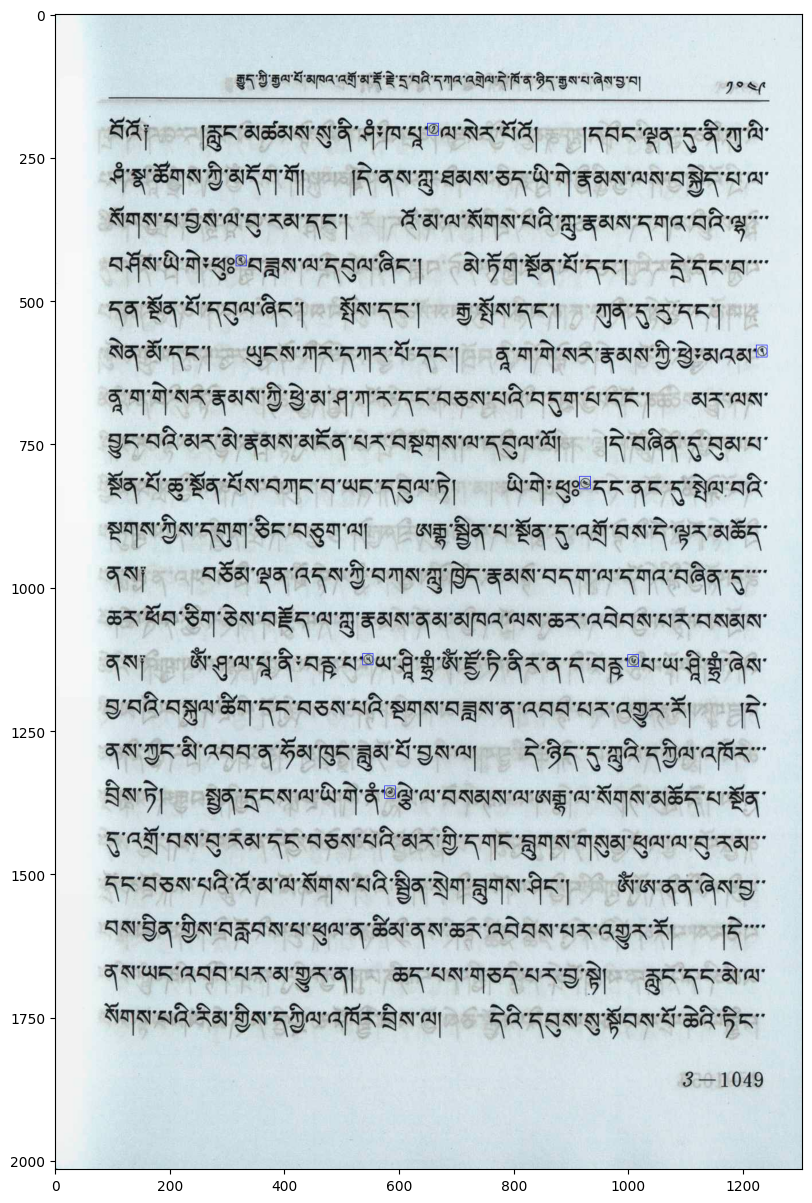

7

In [69]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95848" / "text_pages" / "I1PD958481074.jpg"
matches = find_pedurma_note_number(image_fn, edged=False, imshow=True, check=False)
len(matches)


image 1/1 /Users/10zinten/Developer/OpenPecha/Pedurma/images/W1PD96682/W1PD96682-I1PD96792/text_pages/I1PD967920123.jpg: 1472x1024 13 Notes, 410.2ms
Speed: 13.1ms preprocess, 410.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1472, 1024)
(3956, 2689)
[(719, 3429, 45, 45), (1514, 379, 43, 47), (1316, 2826, 45, 44), (1220, 2670, 42, 46), (412, 3120, 41, 45), (595, 676, 46, 45), (636, 1438, 40, 47), (2219, 1307, 41, 44), (646, 372, 44, 45), (314, 978, 44, 45), (350, 2355, 42, 43), (2013, 999, 43, 44), (2154, 3143, 43, 44)]


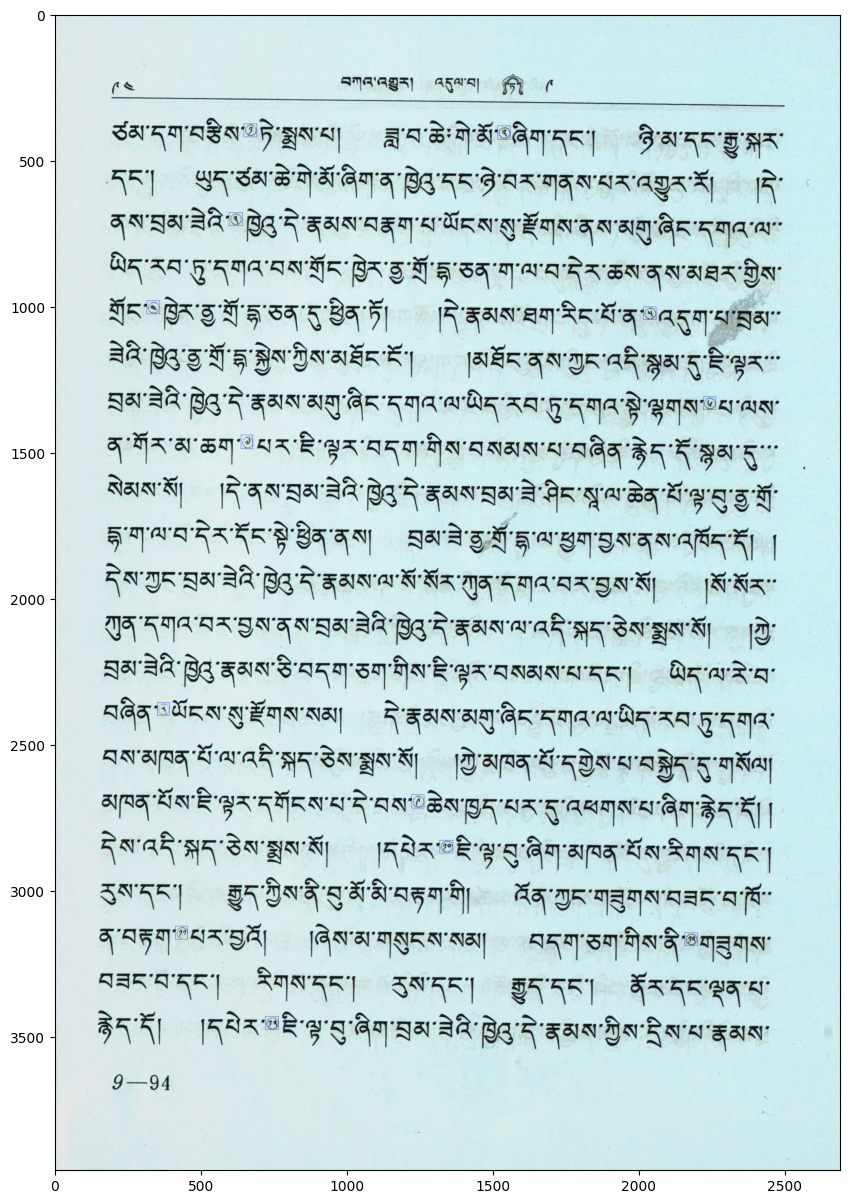

13

In [79]:
image_fn = config.IMAGES_PATH / "W1PD96682" / "W1PD96682-I1PD96792" / "text_pages" / "I1PD967920123.jpg"
matches = find_pedurma_note_number(image_fn, edged=False, imshow=True, check=False)
len(matches)

In [10]:
image_list = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages"
image_gen = image_list.iterdir()

I1PD959061738.jpg

image 1/1 /Users/10zinten/Developer/OpenPecha/Pedurma/images/W1PD95844/W1PD95844-I1PD95906/text_pages/I1PD959061738.jpg: 1472x1024 8 Notes, 386.7ms
Speed: 10.0ms preprocess, 386.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1472, 1024)
(1922, 1318)
[(888, 741, 23, 24), (387, 1358, 21, 24), (655, 433, 22, 22), (323, 894, 22, 25), (125, 1358, 22, 24), (626, 1589, 23, 23), (1073, 819, 23, 22), (1025, 1280, 22, 24)]


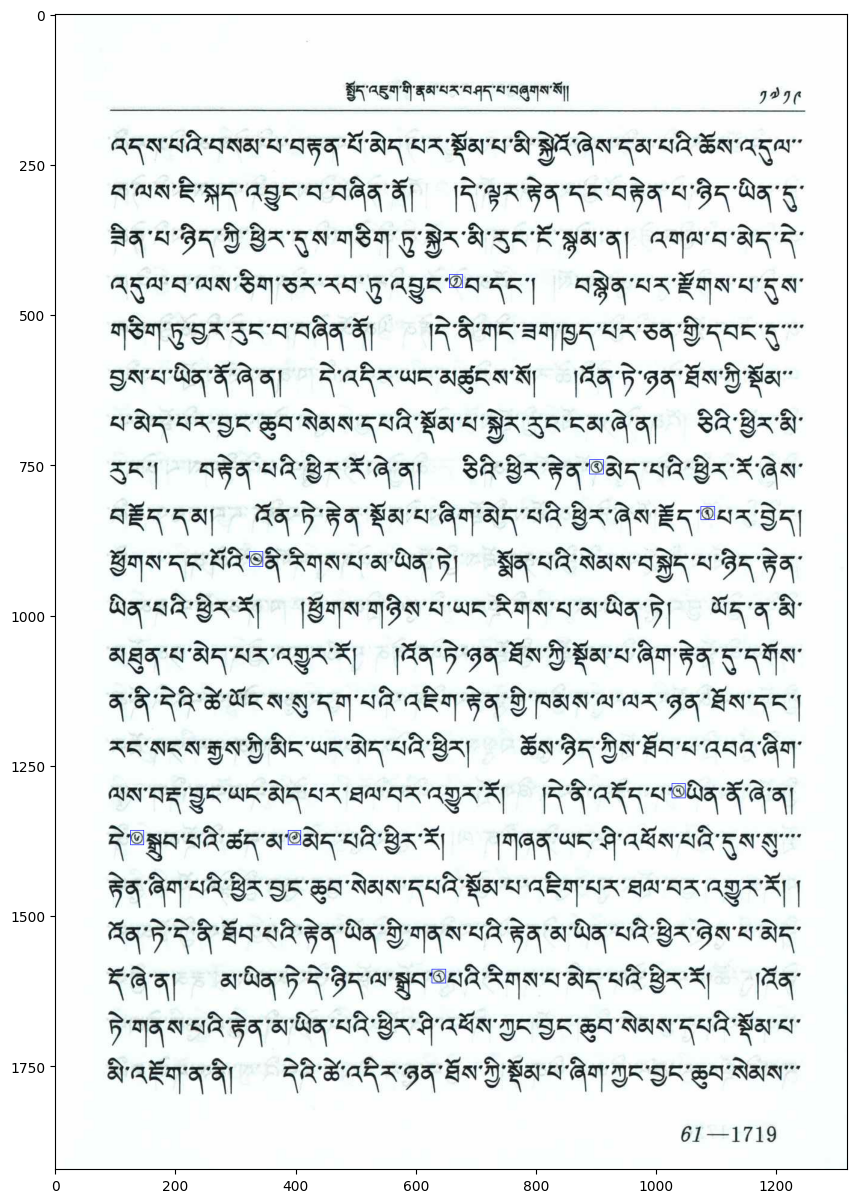

8

In [12]:
image_fn = next(image_gen)
print(image_fn.name)
matches = find_pedurma_note_number(image_fn, imshow=True, check=False)
len(matches)

# Edit Note Marker

In [13]:
def insert_text(image, text, position):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    color = (0, 0, 0) # Blue in BGR
    thickness = 2
    line_type = cv2.LINE_AA
    cv2.putText(image, text, position, font, font_scale, color, thickness, line_type)
    return image

def remove_old_maker(image, position):
    x, y = position
    h, w = 50, 16
    patch = image[0:h, 0:w]
    image[y:y+h, x:x+w] = patch
    return image

def alter_note_maker(image_fn, insert_char=None, output_name="output"):
    image = cv2.imread(str(image_fn))
    matches = find_pedurma_note_number(image, imshow=True)
    if not matches:
        return None
    
    for x, y, w, h in matches:
        image = remove_old_maker(image, (x, y))
        if insert_char:
            insert_text(image, insert_char, (x, y+20))
            output_fn = f"{output_name}_{insert_char}.png"
        else:
            # insert black circle covering the note maker
            cv2.circle(image, (x+7, y+15), 7, (65, 66, 65), -1)
            output_fn = f"{output_name}_circle.png"

    output_path = Path("test") / output_fn
    cv2.imwrite(str(output_path), image)
    plt.imshow(image)
    plt.show()

    return image

In [30]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460249.jpg"
output_name = image_fn.stem
image_new_note_maker = alter_note_maker(image_fn, "", output_name)
image_new_note_maker = alter_note_maker(image_fn, "*", output_name)

[ WARN:0@1248.048] global loadsave.cpp:248 findDecoder imread_('/Users/10zinten/Developer/OpenPecha/Pedurma/images/W1PD95844/W1PD95844-I1PD95846/images/I1PD958460249.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'copy'

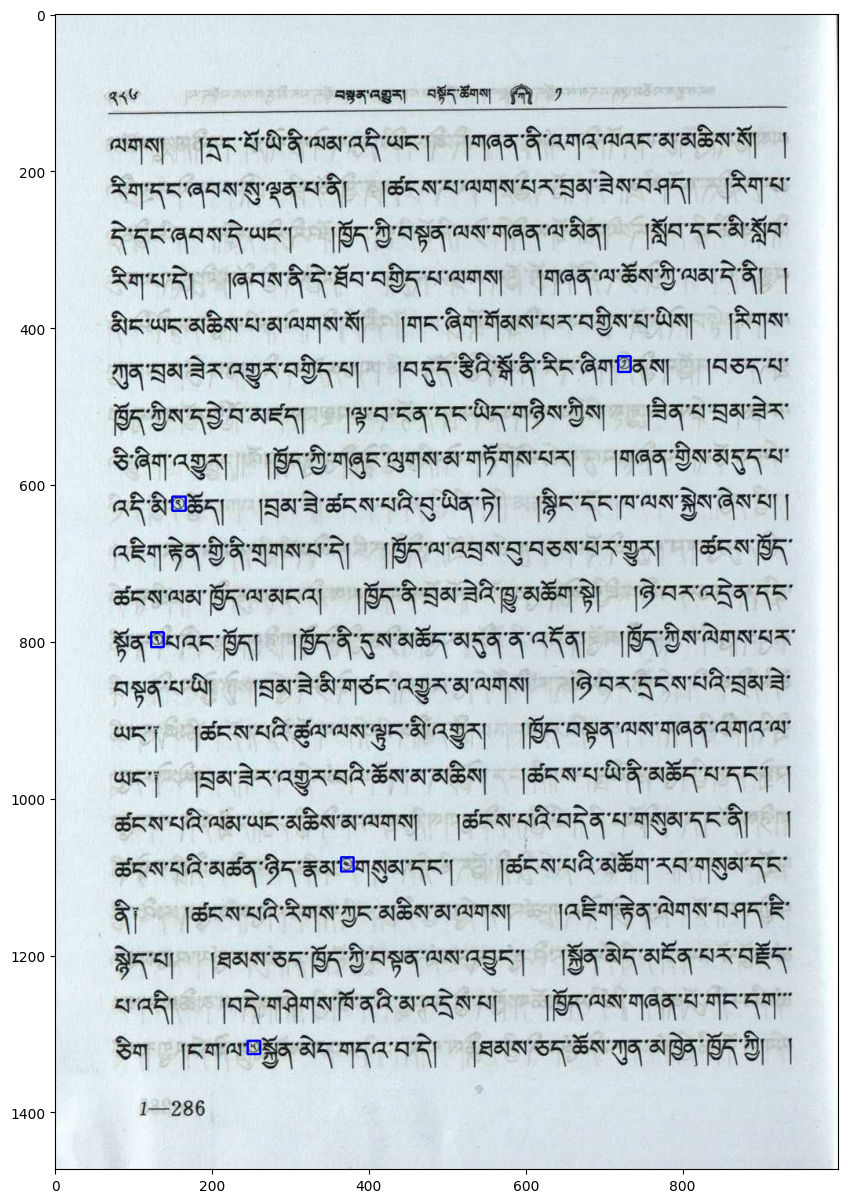

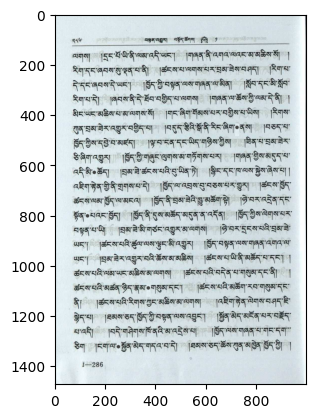

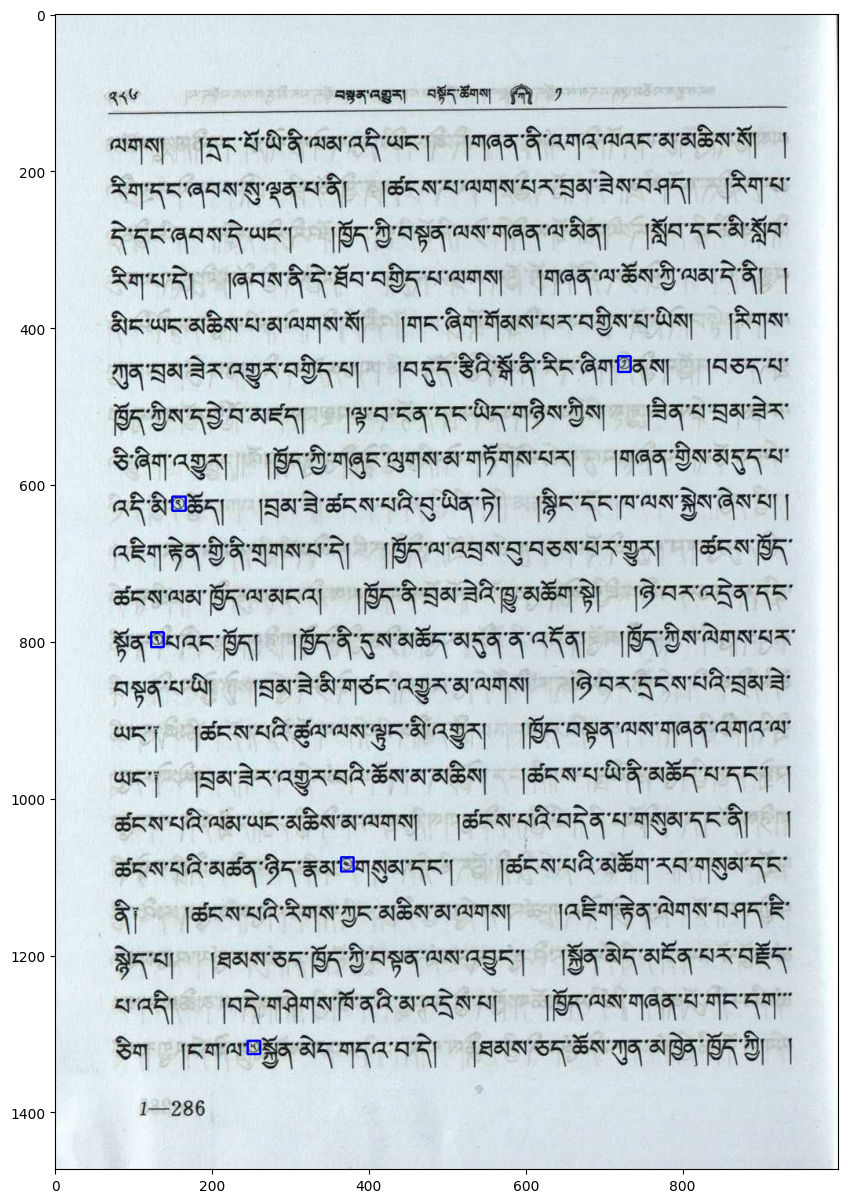

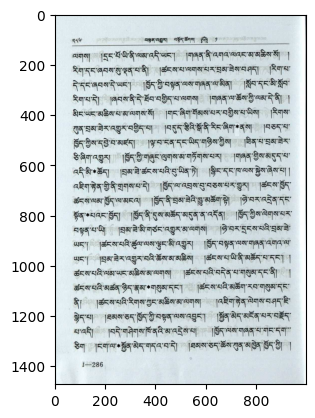

In [37]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460324.jpg"
output_name = image_fn.stem
image_new_note_maker = alter_note_maker(image_fn, "", output_name)
image_new_note_maker = alter_note_maker(image_fn, "*", output_name)

## Generate Yolo Training

In [83]:
yolo_training_data_path = config.NOTE_DETECTION_TRAINING_DATA / "data_v3"
yolo_training_data_path.mkdir(parents=True, exist_ok=True)

train_path = yolo_training_data_path /  "train"
train_images_path = train_path / "images"
train_images_path.mkdir(parents=True, exist_ok=True)
train_labels_path = train_path / "labels"
train_labels_path.mkdir(parents=True, exist_ok=True)

valid_path = yolo_training_data_path / "valid"
valid_images_path = valid_path / "images"
valid_images_path.mkdir(parents=True, exist_ok=True)
valid_labels_path = valid_path / "labels"
valid_labels_path.mkdir(parents=True, exist_ok=True)

In [85]:
def generate_yolo_training_data_for_dir(images_path, prefix, page_type):
    dest_images_path = train_images_path / page_type
    dest_images_path.mkdir(parents=True, exist_ok=True)
    labels_path = train_labels_path / page_type
    labels_path.mkdir(parents=True, exist_ok=True)
    step = 0
    for image_fn in images_path.iterdir():
        if page_type == "text_pages":
            matches_images_path = train_images_path.parent / "matches" / image_fn.stem 
            matches_images_path.mkdir(parents=True, exist_ok=True)
        if step > 5000: break
        if not image_fn.name.endswith(".jpg"): continue
        print(f"\t\t-{image_fn.name} ...")
        dest_image_fn = dest_images_path / f"{prefix}_{image_fn.name}"
        shutil.copy(str(image_fn), str(dest_image_fn))
        label_fn =  labels_path / f"{prefix}_{image_fn.stem}.txt"
        if label_fn.is_file(): continue
        image = cv2.imread(str(image_fn))
        img_height, img_width, _ = image.shape
        matches = find_pedurma_note_number(image, check=False)
        if not matches: continue
        with label_fn.open("w+") as f:
            for i, (x, y, mw, mh) in enumerate(matches):
                if page_type == "text_pages":
                    match_img = image[y:y+mh, x:x+mw]
                    match_img_name = f"{i+1:02}_{dest_image_fn.stem}.jpg"
                    match_img_fn = matches_images_path / match_img_name
                    cv2.imwrite(str(match_img_fn), match_img)
                else:
                    match_img_name = "" 
                x_center = round(((2*x+mw) / 2) / img_width, 6)
                y_center = round(((2*y+mw) / 2) / img_height, 6)
                w = round(mw / img_width, 6)
                h = round(mh / img_height, 6)
                label = f"{match_img_name} 0 {x_center} {y_center} {w} {h}".strip() + "\n"
                f.write(label)
        step += 1

In [86]:
def generate_yolo_training_data(works_path):
    for work_path in works_path.iterdir():
        if not work_path.is_dir(): continue
        print("Processing", work_path.name, "...")
        for vol_path in work_path.iterdir():
            print("\t-", vol_path.name, "...")
            if not vol_path.is_dir(): continue
            text_pages_path = vol_path / "text_pages"
            generate_yolo_training_data_for_dir(
                images_path=text_pages_path,
                prefix=work_path.name, 
                page_type=text_pages_path.name
            )
            note_pages_path = vol_path / "note_pages"
            generate_yolo_training_data_for_dir(
                images_path=note_pages_path,
                prefix=work_path.name,
                page_type=note_pages_path.name
            )

In [87]:
generate_yolo_training_data(config.IMAGES_PATH)

Processing W1PD96682 ...
	- .DS_Store ...
	- W1PD96682-I1PD96792 ...
		-I1PD967920679.jpg ...

0: 1472x992 17 Notes, 335.6ms
Speed: 10.3ms preprocess, 335.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1472, 992)
(4014, 2647)
		-I1PD967920137.jpg ...

0: 1472x1024 11 Notes, 406.7ms
Speed: 11.5ms preprocess, 406.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1472, 1024)
(3956, 2681)
		-I1PD967920651.jpg ...

0: 1472x992 12 Notes, 354.0ms
Speed: 52.9ms preprocess, 354.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1472, 992)
(4014, 2669)
		-I1PD967920645.jpg ...

0: 1472x992 9 Notes, 393.0ms
Speed: 10.1ms preprocess, 393.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1472, 992)
(4014, 2672)
		-I1PD967920123.jpg ...

0: 1472x1024 13 Notes, 393.2ms
Speed: 11.1ms preprocess, 393.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1472, 1024)
(3956, 2689)
		-I1PD967920692.jpg ...

0: 1472x992 16 Notes, 355.4ms
Speed: 11.5ms preprocess, 3

FileExistsError: [Errno 17] File exists: '/Users/10zinten/Developer/OpenPecha/Pedurma/pedurma-detect-durchen-notes/traindata/note_detection/data_v3/train/matches/.DS_Store'

### Check Min length of longer size of images

In [13]:
image_sizes = []
for img_fn in images_path.iterdir():
    if not img_fn.name.endswith(".jpg"): continue
    h, w, _ = cv2.imread(str(img_fn)).shape
    image_sizes.append(h)

print(min(image_sizes))

1460


## Generate Note Classifier Training Data

In [14]:
def gen_note_classifier_training_data(images_path):
    data_save_path = config.NOTE_CLASSIFIER_TRAINING_DATA / f"todo_{images_path.parent.parent.name}"
    data_save_path.mkdir(parents=True, exist_ok=True)
    total_matches = 0
    for image_fn in images_path.iterdir():
        if total_matches > 250: break
        if not image_fn.name.endswith(".jpg"): continue
        print(f"Running {image_fn.name} ...")
        image = cv2.imread(str(image_fn))
        matches = find_pedurma_note_number(image, check=False)
        if list(data_save_path.glob(f"{image_fn.stem}_*")): continue
        if not matches: continue
        total_matches += len(matches)
        for i, (x, y, w, h) in enumerate(matches):
            match = image[y:y+h, x:x+w]
            match_name = f"{image_fn.stem}_{i+1:02}.jpg"
            match_path = data_save_path / match_name
            cv2.imwrite(str(match_path), match)

In [16]:
images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "note_pages"
gen_note_classifier_training_data(images_path)

Running I1PD959061062.jpg ...

0: 1472x992 89 Notes, 369.0ms
Speed: 11.0ms preprocess, 369.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1472, 992)
(1928, 1284)
[(403, 251, 22, 23), (746, 253, 22, 23), (990, 470, 22, 23), (319, 1006, 21, 22), (676, 684, 22, 23), (641, 576, 22, 22), (1108, 957, 22, 22), (371, 1330, 21, 22), (950, 1497, 21, 23), (1105, 1335, 22, 22), (961, 1064, 21, 21), (691, 738, 21, 21), (652, 1766, 22, 22), (730, 1063, 21, 21), (575, 1116, 22, 22), (1005, 254, 22, 23), (872, 577, 22, 22), (1097, 1119, 22, 22), (1104, 579, 22, 22), (1105, 1173, 22, 23), (503, 521, 20, 23), (1108, 795, 21, 23), (161, 411, 22, 23), (717, 361, 22, 22), (973, 901, 23, 23), (728, 468, 21, 23), (685, 1279, 22, 22), (236, 574, 21, 22), (270, 1222, 21, 22), (163, 250, 21, 22), (447, 1386, 22, 22), (664, 954, 21, 22), (1040, 1552, 22, 23), (875, 956, 21, 22), (170, 1492, 23, 22), (652, 1225, 21, 22), (407, 952, 22, 23), (401, 1765, 22, 22), (929, 1226, 21, 23), (553, 1062, 21, 22)

## Generate Note Number Recognittion Dataset

In [25]:
def gen_note_num_recognition_dataset(images_path):
    data_save_path = config.NOTE_NUM_RECOGNITION_DATASET / "todo"
    data_save_path.mkdir(parents=True, exist_ok=True)
    for image_fn in images_path.iterdir():
        if not image_fn.name.endswith(".jpg"): continue
        print(f"Running {image_fn.name} ...")
        image = cv2.imread(str(image_fn))
        matches = find_pedurma_note_number(image, check=False)
        if not matches or len(matches) > 15: continue 
        sorted_matches = sort_matches(matches)
        if list(data_save_path.glob(f"{image_fn.stem}_*")): continue
        if not matches: continue
        for i, (x, y, w, h) in enumerate(sorted_matches):
            match = image[y:y+h, x:x+w]
            match_name = f"{image_fn.stem}_{i+1:02}.jpg"
            match_path = data_save_path / match_name
            cv2.imwrite(str(match_path), match)

In [ ]:
images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images"
gen_note_num_recognition_dataset(images_path)

In [37]:
def clean_step_01(images_path):
    data_save_path = config.NOTE_NUM_RECOGNITION_DATASET / "todo"
    data_save_path.mkdir(parents=True, exist_ok=True)
    counter = defaultdict(int)
    for image_fn in images_path.iterdir():
        if not image_fn.name.endswith(".jpg"): continue
        print(f"Running {image_fn.name} ...")
        note_num_list = list(data_save_path.glob(f"{image_fn.stem}_*"))
        if not note_num_list or len(note_num_list) <= 8: continue
        dest_dir = data_save_path / f"{len(note_num_list)}_{counter[len(note_num_list)]:04}"
        dest_dir.mkdir(parents=True, exist_ok=True)
        for note_num_fn in note_num_list:
            dest_note_num_fn = dest_dir / note_num_fn.name
            shutil.move(str(note_num_fn), str(dest_note_num_fn))
        counter[len(note_num_list)] += 1

In [ ]:
# images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "images"
# clean_step_01(images_path)

In [ ]:
data_save_path = config.NOTE_NUM_RECOGNITION_DATASET / "todo"
for class_path in data_save_path.iterdir():
    if class_path.name.startswith(".DS_Store"): continue
    print(class_path.name)
    for note_fn in class_path.iterdir():
        if note_fn.name.startswith(".DS_Store"): continue
        h, w, _ = cv2.imread(str(note_fn)).shape
        if h > 50 or w > 50:
            print("detection error:", note_fn)
            note_fn.unlink()
            print(note_fn)


0: 1472x992 6 Notes, 335.3ms
Speed: 10.0ms preprocess, 335.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1472, 992)
(1922, 1282)
1 218 197


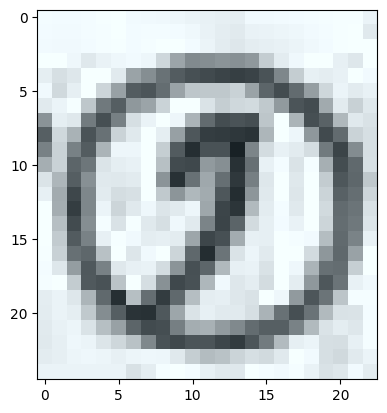

2 332 350


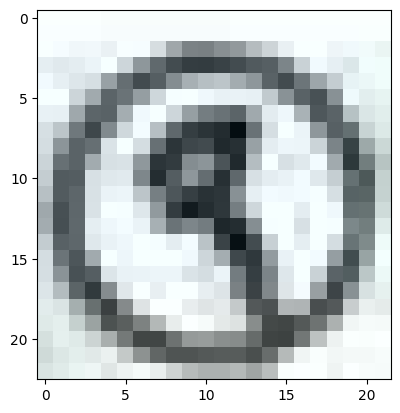

3 492 348


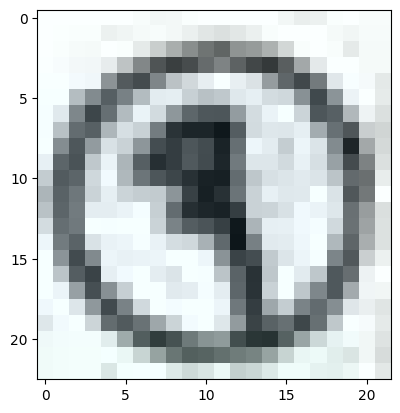

4 998 340


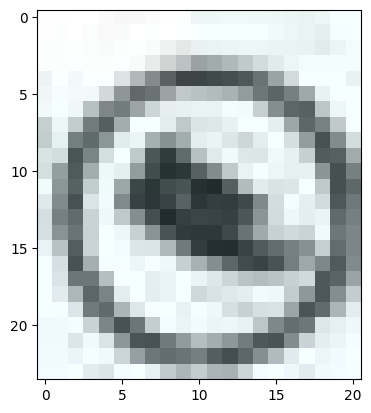

5 1077 722


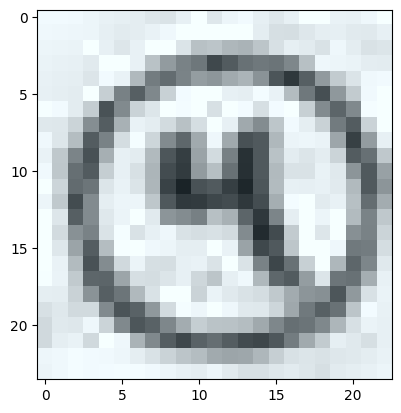

6 576 1269


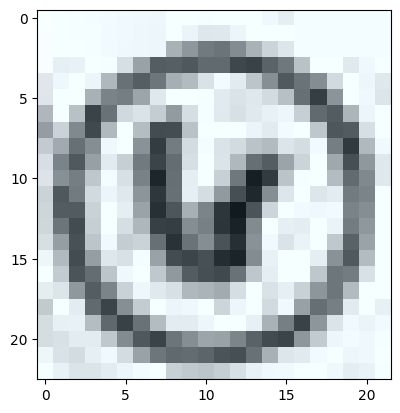

In [35]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "images" / "I1PD959060188.jpg"
image = cv2.imread(str(image_fn))
matches = find_pedurma_note_number(image, check=False)
sorted_matches = sort_matches(matches)
for i, (x, y, w, h) in enumerate(sorted_matches):
    match = image[y:y+h, x:x+w]
    
    print(i+1, x, y)
    plt.imshow(match)
    plt.show()
    